In [26]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

In [27]:
df = pd.read_csv("./data/finance/febaban1.csv",parse_dates=[0],index_col=0)
df.head()

,Abandono
Fecha,
2019-02-01,164
2019-02-02,63
2019-02-03,239
2019-02-04,2
2019-02-05,502


In [28]:
print(df.index.min())
print(df.index.max())


2019-02-01 00:00:00
2020-02-15 00:00:00


In [29]:
df.dtypes

Abandono    int64
dtype: object

In [30]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df['week']=[x.week for x in df.index]
df.head()

,Abandono,weekday,month,week
Fecha,,,,
2019-02-01,164,4,2,5
2019-02-02,63,5,2,5
2019-02-03,239,6,2,5
2019-02-04,2,0,2,6
2019-02-05,502,1,2,6


In [31]:
df.describe()

,Abandono,weekday,month,week
count,43.000000,43.000000,43.0,43.000000
mean,135.930233,3.046512,2.0,6.790698
std,152.267683,2.023122,0.0,1.145553
min,2.000000,0.000000,2.0,5.000000
25%,21.500000,1.000000,2.0,6.000000
50%,102.000000,3.000000,2.0,7.000000
75%,188.500000,5.000000,2.0,7.500000
max,748.000000,6.000000,2.0,9.000000


In [32]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
# load dataset
values = df['Abandono'].values

# ensure all data is float
values = values.astype('int64')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.565684,-0.836461,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,5.0,2.0
1,-0.836461,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,6.0,2.0
2,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,0.0,2.0
3,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113,1.0,2.0
4,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113,-0.930295,2.0,2.0


In [34]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

C:\Users\3127523\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,5.0,2.0,-0.565684,-0.836461,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456
1,6.0,2.0,-0.836461,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595
2,0.0,2.0,-0.364611,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914
3,1.0,2.0,-1.000000,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113
4,2.0,2.0,0.340483,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113,-0.930295
5,3.0,2.0,-0.466488,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113,-0.930295,-0.908847
6,4.0,2.0,-0.522788,-0.710456,-0.986595,-0.983914,-0.646113,-0.930295,-0.908847,-0.938338
7,5.0,2.0,-0.710456,-0.986595,-0.983914,-0.646113,-0.930295,-0.908847,-0.938338,-0.756032
8,6.0,2.0,-0.986595,-0.983914,-0.646113,-0.930295,-0.908847,-0.938338,-0.756032,-0.957105
9,0.0,2.0,-0.983914,-0.646113,-0.930295,-0.908847,-0.938338,-0.756032,-0.957105,-0.989276


In [35]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[7-5:28]
valid_target=target_data[7-5:28]

training_data = training_data[0:28]
target_data=target_data[0:28]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(28, 9) (28,) (26, 9) (26,)


In [62]:
def crear_modeloEmbeddings():
    emb_dias = 8 #tamanio profundidad de embeddings
    emb_meses = 2

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [97]:
EPOCHS=350

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 8)         64          dias[0][0]                       
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 2)         26          meses[0][0]                      
___________________________________________________________________________________________

C:\Users\3127523\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28 samples, validate on 26 samples
Epoch 1/350
28/28 [==============================] - 1s 25ms/step - loss: 0.7339 - MSE: 0.5878 - val_loss: 0.7200 - val_MSE: 0.5682
Epoch 2/350
28/28 [==============================] - 0s 163us/step - loss: 0.7272 - MSE: 0.5779 - val_loss: 0.7133 - val_MSE: 0.5586
Epoch 3/350
28/28 [==============================] - 0s 286us/step - loss: 0.7205 - MSE: 0.5681 - val_loss: 0.7066 - val_MSE: 0.5490
Epoch 4/350
28/28 [==============================] - 0s 143us/step - loss: 0.7137 - MSE: 0.5583 - val_loss: 0.6999 - val_MSE: 0.5395
Epoch 5/350
28/28 [==============================] - 0s 286us/step - loss: 0.7069 - MSE: 0.5485 - val_loss: 0.6934 - val_MSE: 0.5304
Epoch 6/350
28/28 [==============================] - 0s 286us/step - loss: 0.7003 - MSE: 0.5393 - val_loss: 0.6866 - val_MSE: 0.5209
Epoch 7/350
28/28 [==============================] - 0s 358us/step - loss: 0.6934 - MSE: 0.5296 - val_loss: 0.6798 - val_MSE: 0.5118
Epoch 8/350
28/28 [=======

Epoch 63/350
28/28 [==============================] - 0s 0us/step - loss: 0.3035 - MSE: 0.1564 - val_loss: 0.3029 - val_MSE: 0.1587
Epoch 64/350
28/28 [==============================] - 0s 558us/step - loss: 0.3001 - MSE: 0.1543 - val_loss: 0.2998 - val_MSE: 0.1569
Epoch 65/350
28/28 [==============================] - 0s 0us/step - loss: 0.2967 - MSE: 0.1524 - val_loss: 0.2968 - val_MSE: 0.1553
Epoch 66/350
28/28 [==============================] - 0s 558us/step - loss: 0.2934 - MSE: 0.1506 - val_loss: 0.2938 - val_MSE: 0.1538
Epoch 67/350
28/28 [==============================] - 0s 0us/step - loss: 0.2901 - MSE: 0.1489 - val_loss: 0.2909 - val_MSE: 0.1523
Epoch 68/350
28/28 [==============================] - 0s 0us/step - loss: 0.2868 - MSE: 0.1474 - val_loss: 0.2880 - val_MSE: 0.1510
Epoch 69/350
28/28 [==============================] - 0s 558us/step - loss: 0.2837 - MSE: 0.1459 - val_loss: 0.2851 - val_MSE: 0.1497
Epoch 70/350
28/28 [==============================] - 0s 0us/step - lo

Epoch 125/350
28/28 [==============================] - 0s 558us/step - loss: 0.2123 - MSE: 0.1245 - val_loss: 0.2199 - val_MSE: 0.1329
Epoch 126/350
28/28 [==============================] - 0s 0us/step - loss: 0.2118 - MSE: 0.1245 - val_loss: 0.2194 - val_MSE: 0.1329
Epoch 127/350
28/28 [==============================] - 0s 558us/step - loss: 0.2112 - MSE: 0.1244 - val_loss: 0.2189 - val_MSE: 0.1328
Epoch 128/350
28/28 [==============================] - 0s 558us/step - loss: 0.2107 - MSE: 0.1243 - val_loss: 0.2185 - val_MSE: 0.1328
Epoch 129/350
28/28 [==============================] - 0s 0us/step - loss: 0.2102 - MSE: 0.1243 - val_loss: 0.2180 - val_MSE: 0.1328
Epoch 130/350
28/28 [==============================] - 0s 558us/step - loss: 0.2097 - MSE: 0.1242 - val_loss: 0.2176 - val_MSE: 0.1327
Epoch 131/350
28/28 [==============================] - 0s 0us/step - loss: 0.2092 - MSE: 0.1242 - val_loss: 0.2171 - val_MSE: 0.1327
Epoch 132/350
28/28 [==============================] - 0s 197

28/28 [==============================] - 0s 0us/step - loss: 0.1890 - MSE: 0.1247 - val_loss: 0.1987 - val_MSE: 0.1340
Epoch 187/350
28/28 [==============================] - 0s 0us/step - loss: 0.1888 - MSE: 0.1247 - val_loss: 0.1985 - val_MSE: 0.1340
Epoch 188/350
28/28 [==============================] - 0s 648us/step - loss: 0.1885 - MSE: 0.1247 - val_loss: 0.1984 - val_MSE: 0.1341
Epoch 189/350
28/28 [==============================] - 0s 0us/step - loss: 0.1884 - MSE: 0.1248 - val_loss: 0.1982 - val_MSE: 0.1341
Epoch 190/350
28/28 [==============================] - 0s 0us/step - loss: 0.1882 - MSE: 0.1248 - val_loss: 0.1980 - val_MSE: 0.1342
Epoch 191/350
28/28 [==============================] - 0s 0us/step - loss: 0.1880 - MSE: 0.1249 - val_loss: 0.1978 - val_MSE: 0.1342
Epoch 192/350
28/28 [==============================] - 0s 558us/step - loss: 0.1878 - MSE: 0.1249 - val_loss: 0.1977 - val_MSE: 0.1343
Epoch 193/350
28/28 [==============================] - 0s 0us/step - loss: 0.18

Epoch 248/350
28/28 [==============================] - 0s 558us/step - loss: 0.1826 - MSE: 0.1264 - val_loss: 0.1931 - val_MSE: 0.1360
Epoch 249/350
28/28 [==============================] - 0s 0us/step - loss: 0.1825 - MSE: 0.1264 - val_loss: 0.1931 - val_MSE: 0.1360
Epoch 250/350
28/28 [==============================] - 0s 0us/step - loss: 0.1824 - MSE: 0.1264 - val_loss: 0.1930 - val_MSE: 0.1360
Epoch 251/350
28/28 [==============================] - 0s 0us/step - loss: 0.1824 - MSE: 0.1264 - val_loss: 0.1929 - val_MSE: 0.1360
Epoch 252/350
28/28 [==============================] - 0s 558us/step - loss: 0.1823 - MSE: 0.1264 - val_loss: 0.1929 - val_MSE: 0.1360
Epoch 253/350
28/28 [==============================] - 0s 286us/step - loss: 0.1823 - MSE: 0.1265 - val_loss: 0.1929 - val_MSE: 0.1360
Epoch 254/350
28/28 [==============================] - 0s 304us/step - loss: 0.1822 - MSE: 0.1265 - val_loss: 0.1928 - val_MSE: 0.1360
Epoch 255/350
28/28 [==============================] - 0s 286

Epoch 309/350
28/28 [==============================] - 0s 0us/step - loss: 0.1797 - MSE: 0.1274 - val_loss: 0.1907 - val_MSE: 0.1372
Epoch 310/350
28/28 [==============================] - 0s 0us/step - loss: 0.1797 - MSE: 0.1275 - val_loss: 0.1907 - val_MSE: 0.1372
Epoch 311/350
28/28 [==============================] - 0s 559us/step - loss: 0.1797 - MSE: 0.1275 - val_loss: 0.1907 - val_MSE: 0.1372
Epoch 312/350
28/28 [==============================] - 0s 557us/step - loss: 0.1797 - MSE: 0.1275 - val_loss: 0.1907 - val_MSE: 0.1372
Epoch 313/350
28/28 [==============================] - 0s 558us/step - loss: 0.1797 - MSE: 0.1275 - val_loss: 0.1906 - val_MSE: 0.1372
Epoch 314/350
28/28 [==============================] - 0s 0us/step - loss: 0.1796 - MSE: 0.1275 - val_loss: 0.1907 - val_MSE: 0.1372
Epoch 315/350
28/28 [==============================] - 0s 558us/step - loss: 0.1796 - MSE: 0.1275 - val_loss: 0.1907 - val_MSE: 0.1372
Epoch 316/350
28/28 [==============================] - 0s 666

26


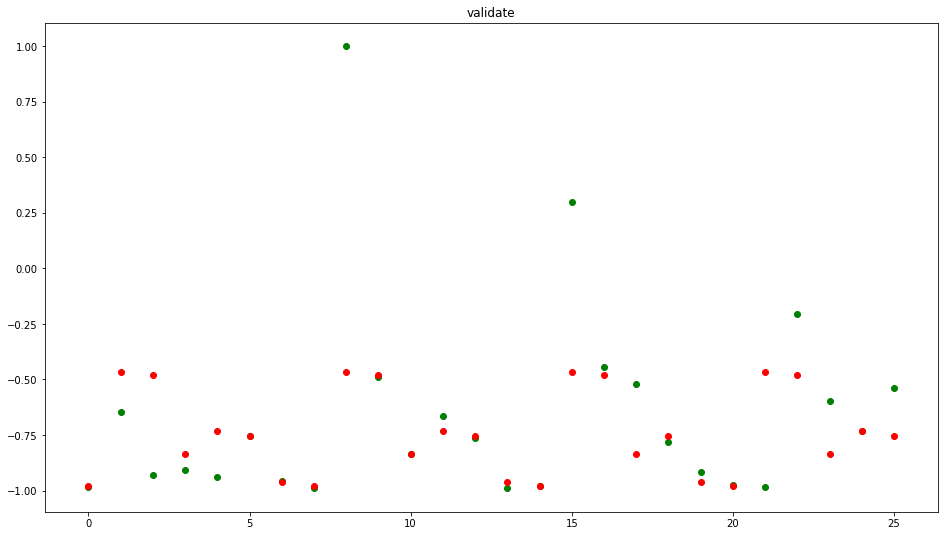

In [98]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

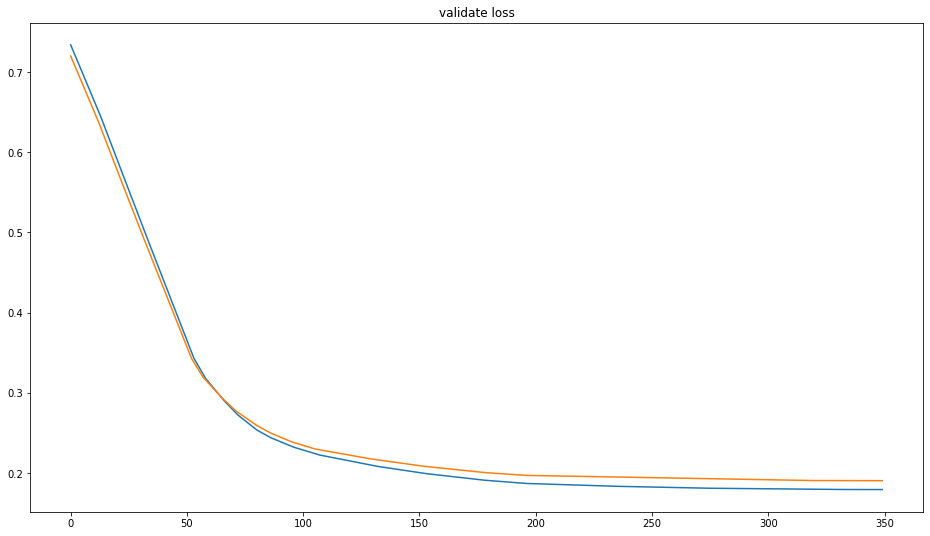

In [99]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

KeyError: 'mean_squared_error'

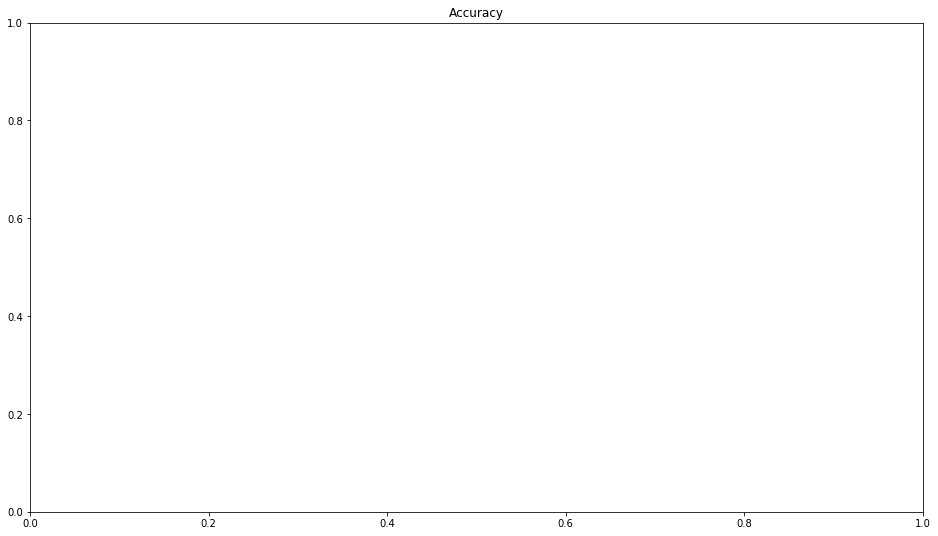

In [100]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [101]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,9.203753,10.056187,-0.852433
1,55.482574,80.120949,-24.638375
2,16.549598,78.496666,-61.947068
3,19.487936,29.424865,-9.936929
4,15.447721,43.798419,-28.350698
5,40.423592,40.420580,0.003013
6,12.876676,12.248575,0.628101
7,8.469169,10.056187,-1.587018
8,281.000000,80.120949,200.879051
9,76.785523,78.496666,-1.711143


In [102]:
compara2.describe()

,real,prediccion,diferencia
count,26.000000,26.000000,26.000000
mean,53.250567,43.162230,10.088337
std,61.615210,27.199280,50.783562
min,8.469169,10.056187,-70.917195
25%,13.519437,16.542647,-2.904749
50%,38.219839,40.420580,-0.044618
75%,68.429625,78.496666,8.461026
max,281.000000,80.120949,200.879051


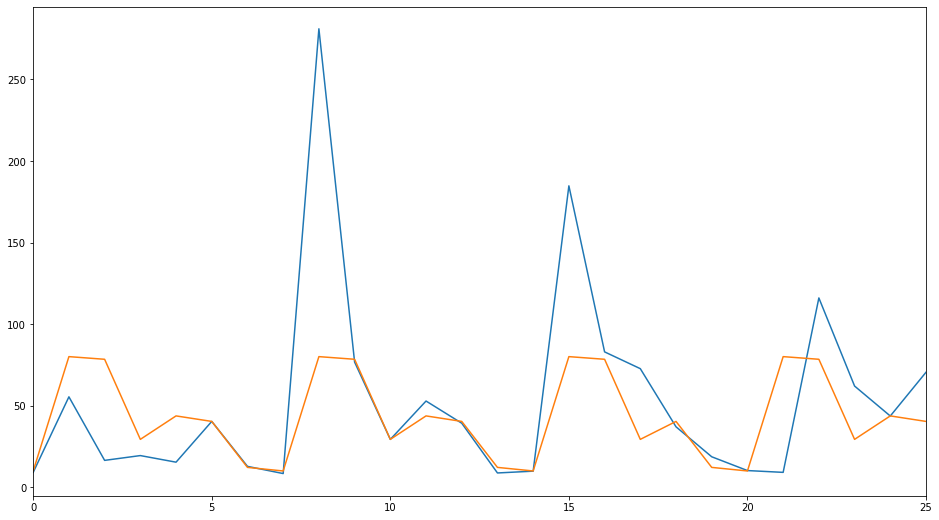

In [103]:
compara2['real'].plot()
compara2['prediccion'].plot()

In [104]:
ultimosDias = df['2020-02-07':'2020-02-15']
ultimosDias

,Abandono,weekday,month,week
Fecha,,,,
2020-02-07,175,4,2,6
2020-02-08,26,5,2,6
2020-02-09,8,6,2,6
2020-02-10,204,0,2,7
2020-02-11,187,1,2,7
2020-02-12,190,2,2,7
2020-02-13,148,3,2,7
2020-02-14,281,4,2,7
2020-02-15,7,5,2,7


In [105]:
# load dataset
values = ultimosDias['Abandono'].values

# ensure all data is float
values = values.astype('int64')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

C:\Users\3127523\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,5.0,2.0,0.226277,-0.861314,-0.992701,0.437956,0.313869,0.335766,0.029197


In [106]:
values = reordenado.values
x_test = values[0:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(1, 1, 9)
[[[ 5.          2.          0.22627737 -0.86131387 -0.99270073
    0.4379562   0.31386861  0.33576642  0.02919708]]]


5.0

In [107]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [108]:
results=[]
for i in range(7):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 5.          2.          0.22627737 -0.86131387 -0.99270073
    0.4379562   0.31386861  0.33576642  0.02919708]]]
pred 1 [[[ 6.         12.         -0.86131387 -0.99270073  0.4379562
    0.31386861  0.33576642  0.02919708 -0.75605416]]]
pred 2 [[[ 0.         12.         -0.99270073  0.4379562   0.31386861
    0.33576642  0.02919708 -0.75605416 -0.94870561]]]
pred 3 [[[ 1.         12.          0.4379562   0.31386861  0.33576642
    0.02919708 -0.75605416 -0.94870561 -0.97075963]]]
pred 4 [[[ 2.         12.          0.31386861  0.33576642  0.02919708
   -0.75605416 -0.94870561 -0.97075963 -0.30237338]]]
pred 5 [[[ 3.         12.          0.33576642  0.02919708 -0.75605416
   -0.94870561 -0.97075963 -0.30237338 -0.31677625]]]
pred 6 [[[ 4.         12.          0.02919708 -0.75605416 -0.94870561
   -0.97075963 -0.30237338 -0.31677625 -0.77388924]]]


In [109]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.75605416], dtype=float32), array([-0.9487056], dtype=float32), array([-0.97075963], dtype=float32), array([-0.30237338], dtype=float32), array([-0.31677625], dtype=float32), array([-0.77388924], dtype=float32), array([-0.63259864], dtype=float32)]


array([[ 40.42057967],
       [ 14.02733094],
       [ 11.00593066],
       [102.57484701],
       [100.60165432],
       [ 37.97717363],
       [ 57.33398652]])

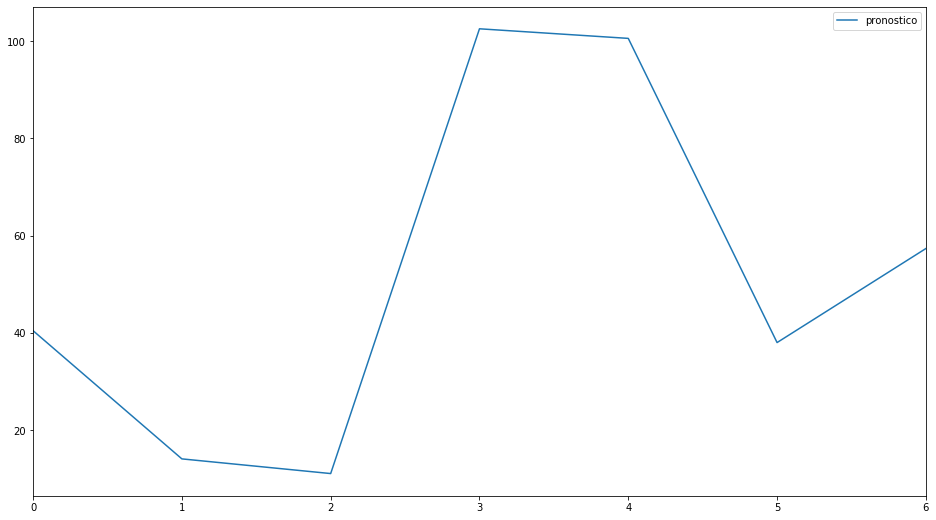

In [110]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_embeddings.csv')

In [111]:
prediccion1SemanaDiciembre

,pronostico
0,40.420580
1,14.027331
2,11.005931
3,102.574847
4,100.601654
5,37.977174
6,57.333987
